# 25/10/08 Visualisation and analysis of FANS count data.

In this notebook, we will work on the long-format data frame generated in `SortStatsFromPDFSortReports.ipynb`. It combines the meta-data, recorded by hand during sample processing, with the count data obtained post-sorting. 

To do:
- explore the data with a variety of plots and summary statistics
- perform inferential analysis on the variables driving cell number differences between groups.

In [1]:
from pathlib import Path
import pandas as pd
import itertools
from plotnine import *
from plotnine import scales
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
# Make pandas display floats nicely without affecting underlying data
pd.set_option("display.float_format", "{:,.2f}".format)

In [3]:
# load in the tidied, long-format FANS data
base_path = Path("/home/tmurphy/phd_work/experiment_383/exp_383_flowCytometry_analysis")
df_path = Path(base_path / "tidied_FANS_data/exp383_tidy_FANS_data_long.csv")
df = pd.read_csv(df_path)

# remind ourselves of the data
df.head()

,animal_id,group_no,inoculum,inoculation_batch,dpi,sample_mass_mg,date_nuc_prep,incubation_time_hrs,population,count_statistic,count_value
0,918310,1,RML,BATCH4,60,246,2025-05-06,19.00,NeuN+,EstTotalCount,"4,359,464.00"
1,917423,19,22L,BATCH3,120,207,2025-05-06,19.67,NeuN+,EstTotalCount,"2,913,658.00"
2,918309,4,CBH,BATCH4,60,240,2025-05-07,16.92,NeuN+,EstTotalCount,"5,017,422.00"
3,916462,1,RML,BATCH1,60,248,2025-05-08,18.50,NeuN+,EstTotalCount,"4,324,274.00"
4,918277,9,RML,BATCH4,90,220,2025-05-08,18.98,NeuN+,EstTotalCount,"5,102,254.00"


In [4]:
# descriptive stats per nucleus population, ignores dpi and inocula
populationStats = (
    df.groupby(["population", "count_statistic"])["count_value"]
        .agg(["count", "mean", "std", "min", "max"])
        .sort_values(by=["count_statistic", "population"])
        .reset_index()
)
#populationStats

In [5]:
# generate summary stats for each experimental group (dpi*inouclum*population)
groupStats = (
    df.groupby(["dpi", "inoculum","population", "count_statistic"])["count_value"]
        .agg(["count", "mean", "std", "min", "max"])
        .sort_values(by=["count_statistic", "population"])
        .reset_index()
)
# save for reference
csvpath = Path("~/phd_work/experiment_383/exp_383_flowCytometry_analysis/tidied_FANS_data/FANS_population_counts_by_group.csv")
groupStats.to_csv(csvpath)
#groupStats

In [6]:
# Ensure dates are encoded correctly
df['date_nuc_prep'] = pd.to_datetime(df['date_nuc_prep'])

In [7]:
# specify an order to the factors columns
dpi_order = [60, 90, 120]
inoc_order = ['CBH', 'RML', 'ME7', '22L']
pop_order = ['NeuN+', 'PU1+', 'SOX10+', 'SOX2+']

In [8]:
# encode necessary cols as ordered categorical variables
df['dpi'] = pd.Categorical(df['dpi'], categories = dpi_order, ordered=True )
df['inoculum'] = pd.Categorical(df['inoculum'], categories = inoc_order, ordered=True )
df['population'] = pd.Categorical(df['population'], categories = pop_order, ordered=True )

In [9]:
# make two dfs with the different count values
df_raw = df[df['count_statistic'] == 'EstTotalCount'].copy()
df_norm = df[df['count_statistic'] == 'EstTotalCount_per_mg'].copy()

In [10]:
# We want to add a column that provides a descriptor of experimental groups
# e.g. 60_dpi_RML
def add_group_label(df, inplace=False):
    """
    Add a 'group_label' column combining dpi, inoculum, and population.
    """
    # Decide whether to modify in place or return a copy
    target = df if inplace==True else df.copy()

    target['group_label'] = (
        target['dpi'].astype(str) + '_dpi_' +
        target['inoculum'].astype(str) + '_' +
        target['population'].astype(str)
    )

    return target

df_raw = add_group_label(df_raw, inplace=True)
df_norm = add_group_label(df_norm, inplace=True)

In [11]:
# make a list containing group_label values in desired order
ordered_groups = [
    f'{d}_dpi_{i}_{p}'
    for d, i, p, in itertools.product(dpi_order, inoc_order, pop_order)
]
#check format
ordered_groups[0:4]

['60_dpi_CBH_NeuN+',
 '60_dpi_CBH_PU1+',
 '60_dpi_CBH_SOX10+',
 '60_dpi_CBH_SOX2+']

In [12]:
def order_fac_levels(df_col, order_list):
    """
    Takes a data frame column and a list of the levels of a factor
    Returns: column as a Categorical with factors ordered per order_list
    """
    ord_col = pd.Categorical(df_col,
                            categories = order_list,
                            ordered=True)
    return ord_col

# set the order
df_raw['group_label'] = order_fac_levels(
    df_raw['group_label'],
    order_list=ordered_groups
)
df_norm['group_label'] = order_fac_levels(
    df_raw['group_label'],
    order_list=ordered_groups
)

In [13]:
# Utility function to display count values nicely
def scale_y_metric():
    """
    Automatically format y-axis values:
    - raw for < 1k
    - 'k' for thousands (1 dp only for values < 10k)
    - 'M' for millions (2 dp)
    """
    def _formatter(values):
        out = []
        for v in values:
            if v < 1_000:
                # Keep integers for small numbers
                out.append(f"{int(v)}")

            elif v < 1_000_000:
                # Thousands:
                # - one decimal place only if < 10k
                # - no decimals if >= 10k
                k = v / 1000
                if k < 10:
                    out.append(f"{k:.1f}k")   # e.g. 1.5k, 9.7k
                else:
                    out.append(f"{k:.0f}k")   # e.g. 12k, 850k

            else:
                # Millions: always two decimals
                out.append(f"{v/1_000_000:.2f}M")

        return out

    return scales.scale_y_continuous(labels=_formatter)


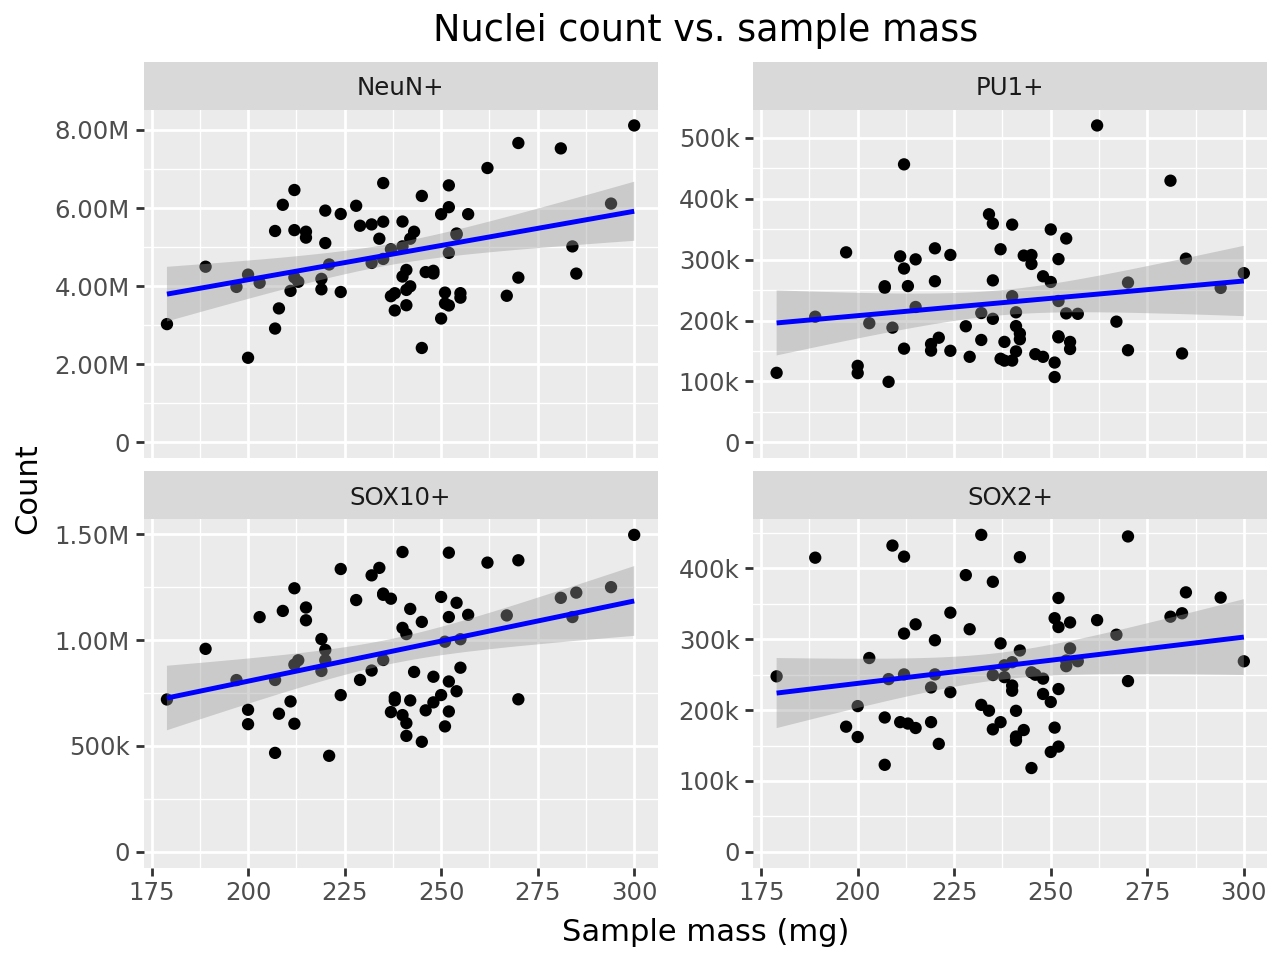

In [14]:
# Plot count versus mass
# stratify by population only
p_mass_byPop = (
    ggplot(data=df_raw, mapping=aes(x='sample_mass_mg', y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_wrap('population', scales='free_y')
    + expand_limits(y=0)
    + scale_y_metric()
    +labs(
        title="Nuclei count vs. sample mass",
        x="Sample mass (mg)",
        y="Count"
    )
)
p_mass_byPop

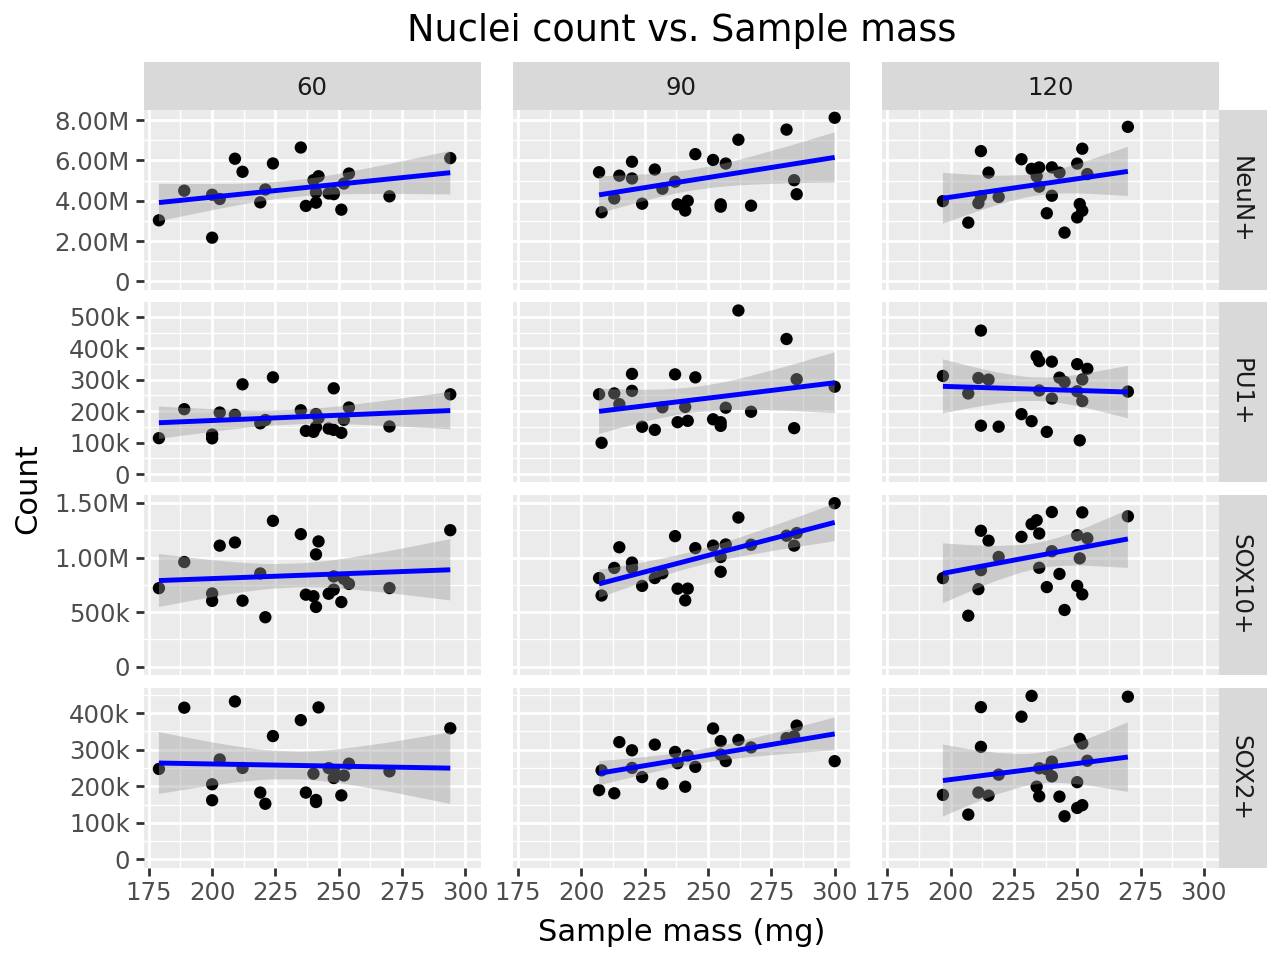

In [15]:
# Plot count versus mass
# stratify by unique  pop*dpi with facet_grid
p_mass_grid = (
    ggplot(data=df_raw, mapping=aes(x='sample_mass_mg', y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    # +facet_wrap('population', scales='free_y')
    +facet_grid('population','dpi',scales='free_y')
    + expand_limits(y=0)
    + scale_y_metric()
    +labs(
        title="Nuclei count vs. Sample mass",
        x="Sample mass (mg)",
        y="Count"
    )
    +theme(panel_spacing_x=0.025)
)
p_mass_grid

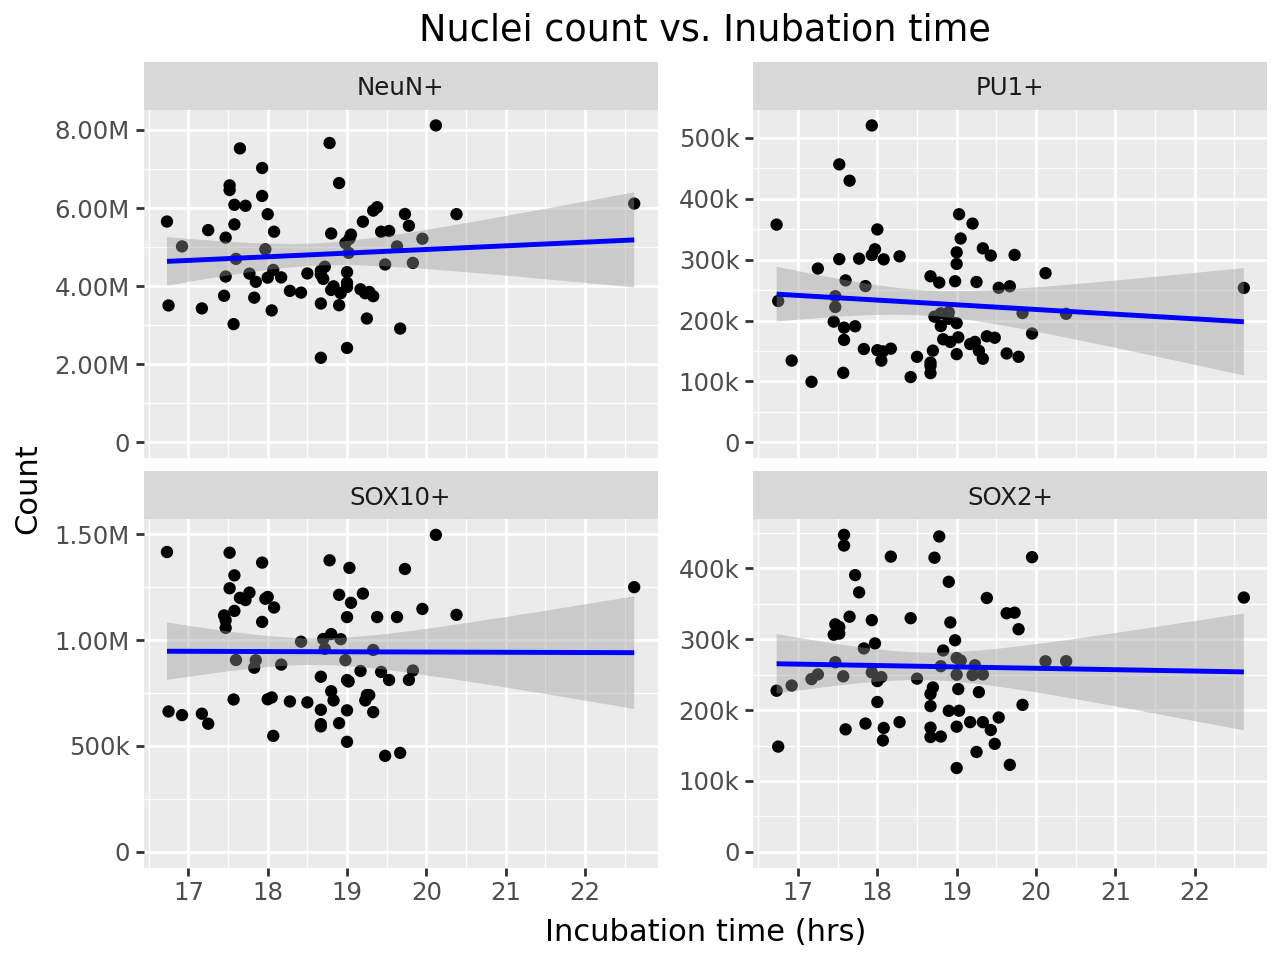

In [16]:
# plot count versus incubation time
p_inc_byPop = (
    ggplot(data=df_raw,
           mapping=aes(x= 'incubation_time_hrs',
                       y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_wrap('population', scales='free_y')
    +expand_limits(y=0)
    +scale_y_metric()
    +labs(
        title="Nuclei count vs. Inubation time",
        x="Incubation time (hrs)",
        y="Count"
    )
)

p_inc_byPop

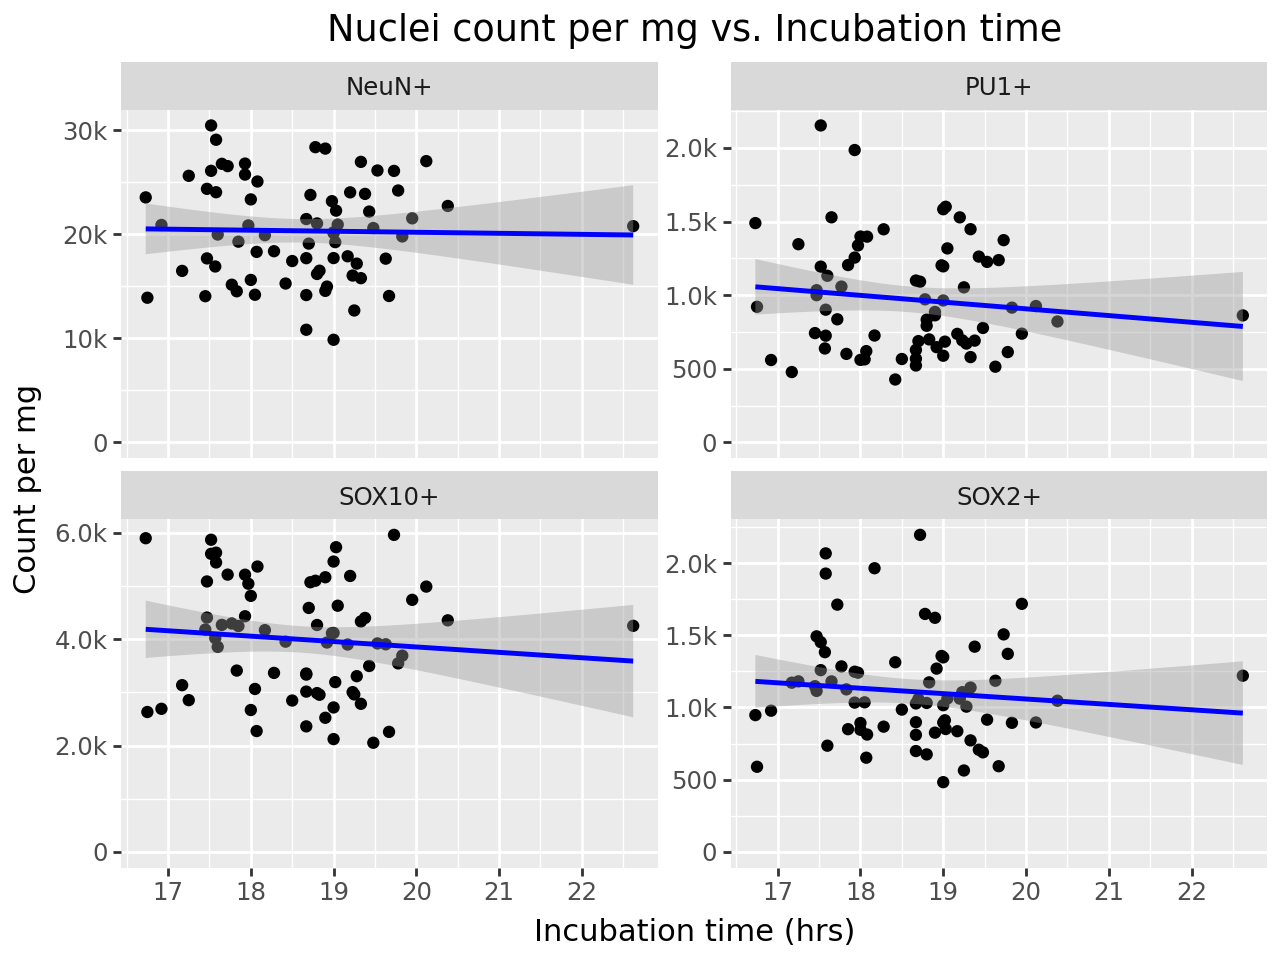

In [17]:
# Repeat the previous plot but for the mass-normalised values
p_inc_byPop_norm = (
    ggplot(data=df_norm,
           mapping=aes(x= 'incubation_time_hrs',
                       y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_wrap('population', scales='free_y')
    +expand_limits(y=0)
    +scale_y_metric()
    +labs(
        title="Nuclei count per mg vs. Incubation time",
        x="Incubation time (hrs)",
        y="Count per mg"
    )
)
p_inc_byPop_norm

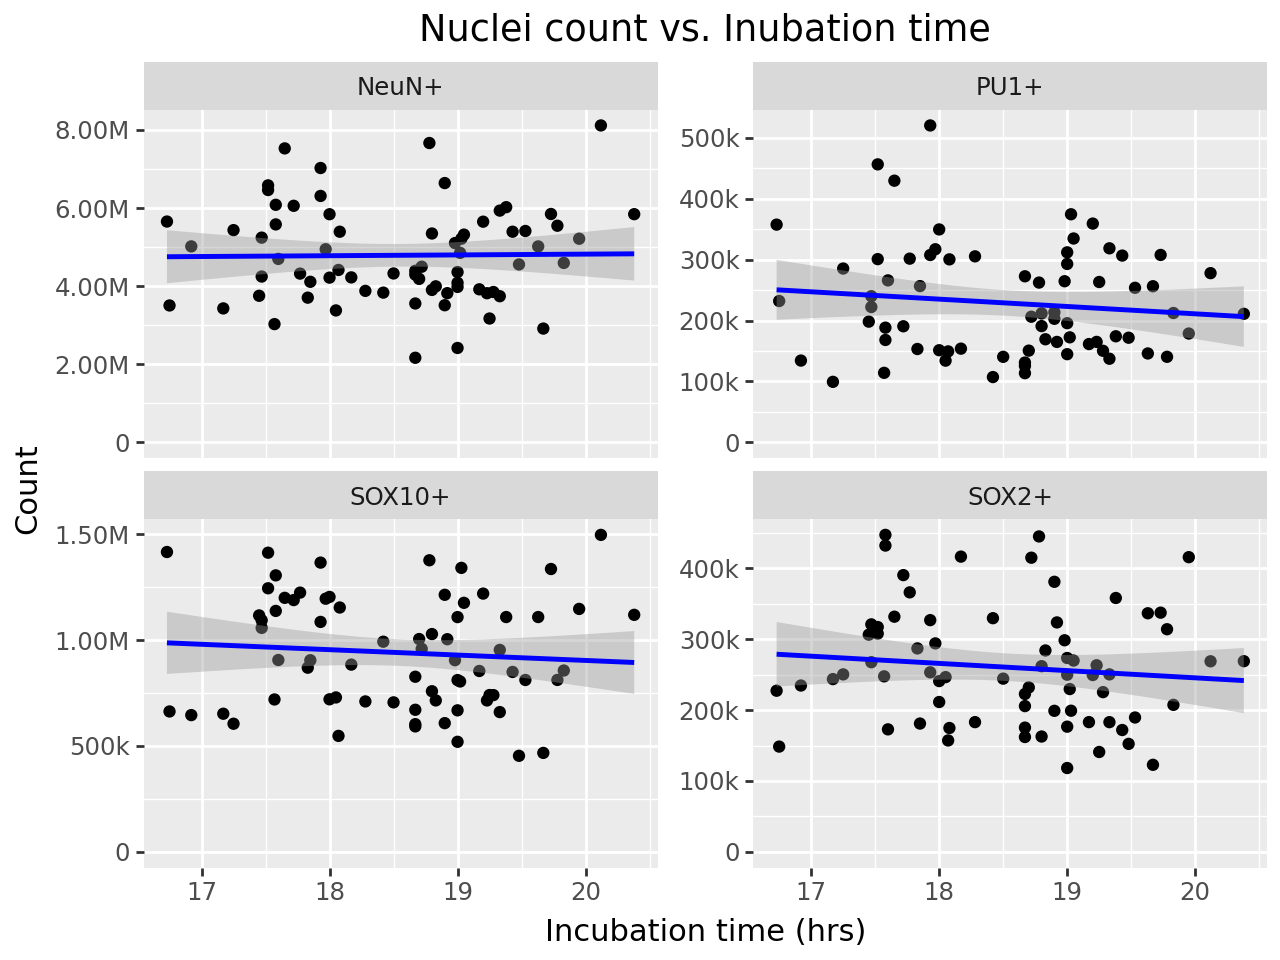

In [18]:
# There is one sample that's a very clear outlier here. 
# remove and replot
df_inc = df_raw[df_raw['incubation_time_hrs'] < 21].copy()

p_inc_raw_noOutlier = (
    ggplot(data=df_inc,
           mapping=aes(x= 'incubation_time_hrs',
                       y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_wrap('population', scales='free_y')
    +expand_limits(y=0)
    +scale_y_metric()
    +labs(
        title="Nuclei count vs. Inubation time",
        x="Incubation time (hrs)",
        y="Count"
    )
)
p_inc_raw_noOutlier

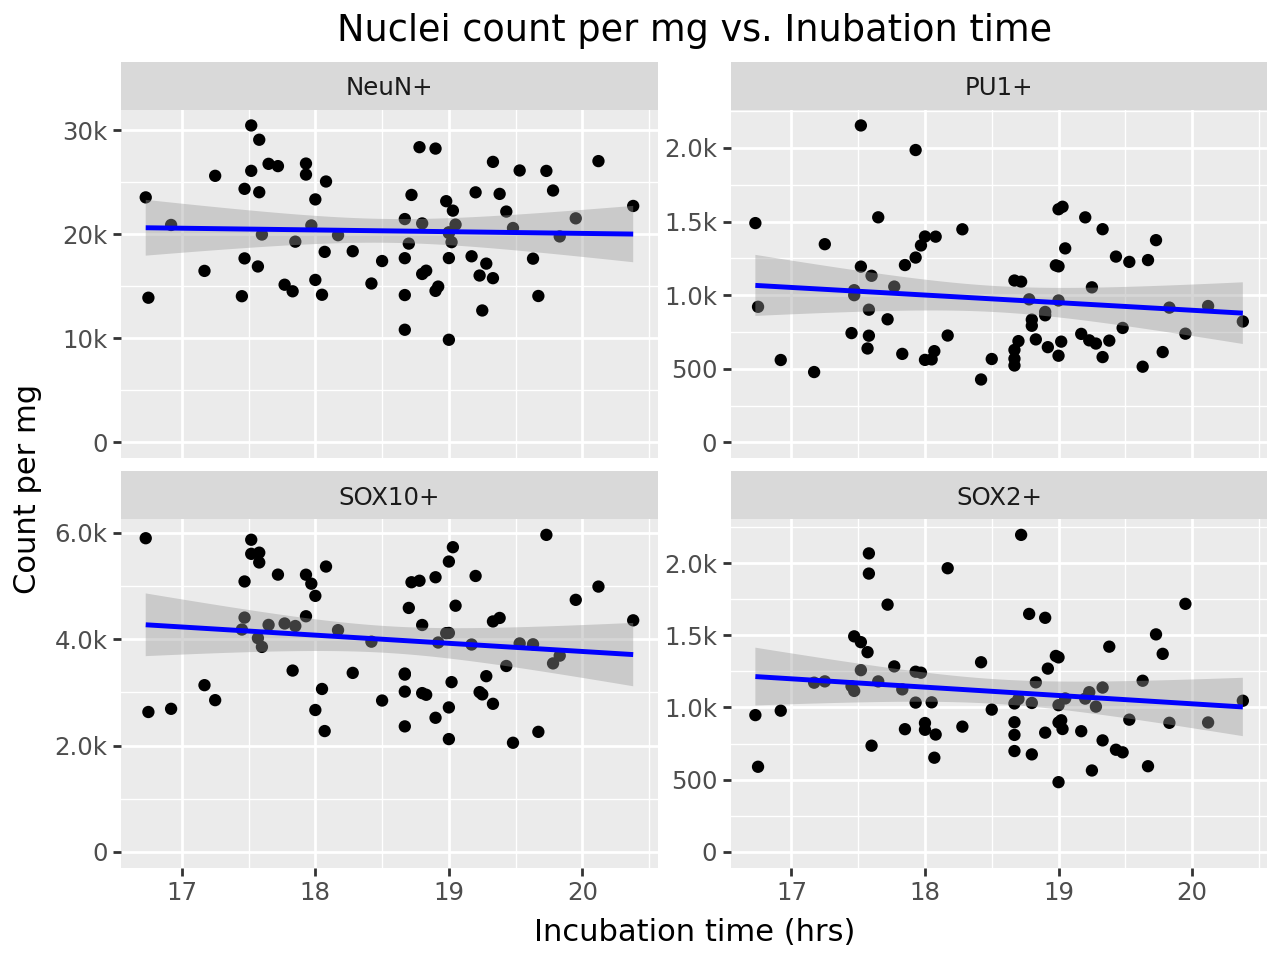

In [19]:
# Repeat the graph minus outlier with mass-normalised data
df_inc_norm = df_norm[df_norm['incubation_time_hrs'] < 21].copy()
p_inc_norm_noOutlier = (
    ggplot(data=df_inc_norm,
           mapping=aes(x= 'incubation_time_hrs',
                       y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_wrap('population', scales='free_y')
    +expand_limits(y=0)
    +scale_y_metric()
    +labs(
        title="Nuclei count per mg vs. Inubation time",
        x="Incubation time (hrs)",
        y="Count per mg"
    )
)
p_inc_norm_noOutlier

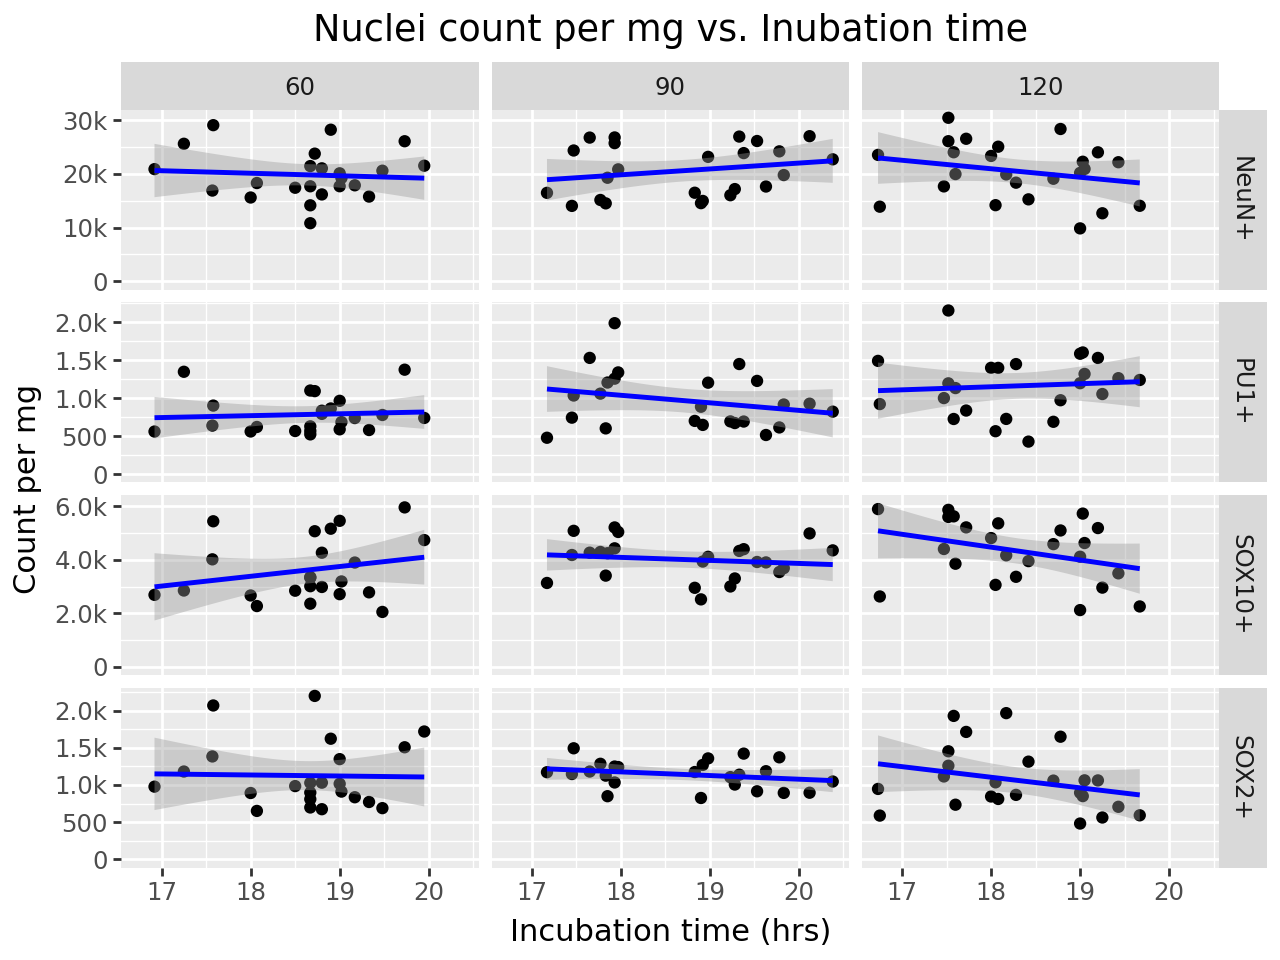

In [20]:
# Plot counts per mg versus incubation time. 
# outlier removed
# stratify by pop*dpi

df_inc = df_raw[df_raw['incubation_time_hrs'] < 21].copy()

p_inc_norm_grid = (
    ggplot(data=df_inc_norm, mapping=aes(
        x= 'incubation_time_hrs',
        y='count_value')
          ) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_grid('population', 'dpi', scales='free_y')
    +expand_limits(y=0)
    +scale_y_metric()
    +labs(
        title="Nuclei count per mg vs. Inubation time",
        x="Incubation time (hrs)",
        y="Count per mg"
    )
)
p_inc_norm_grid

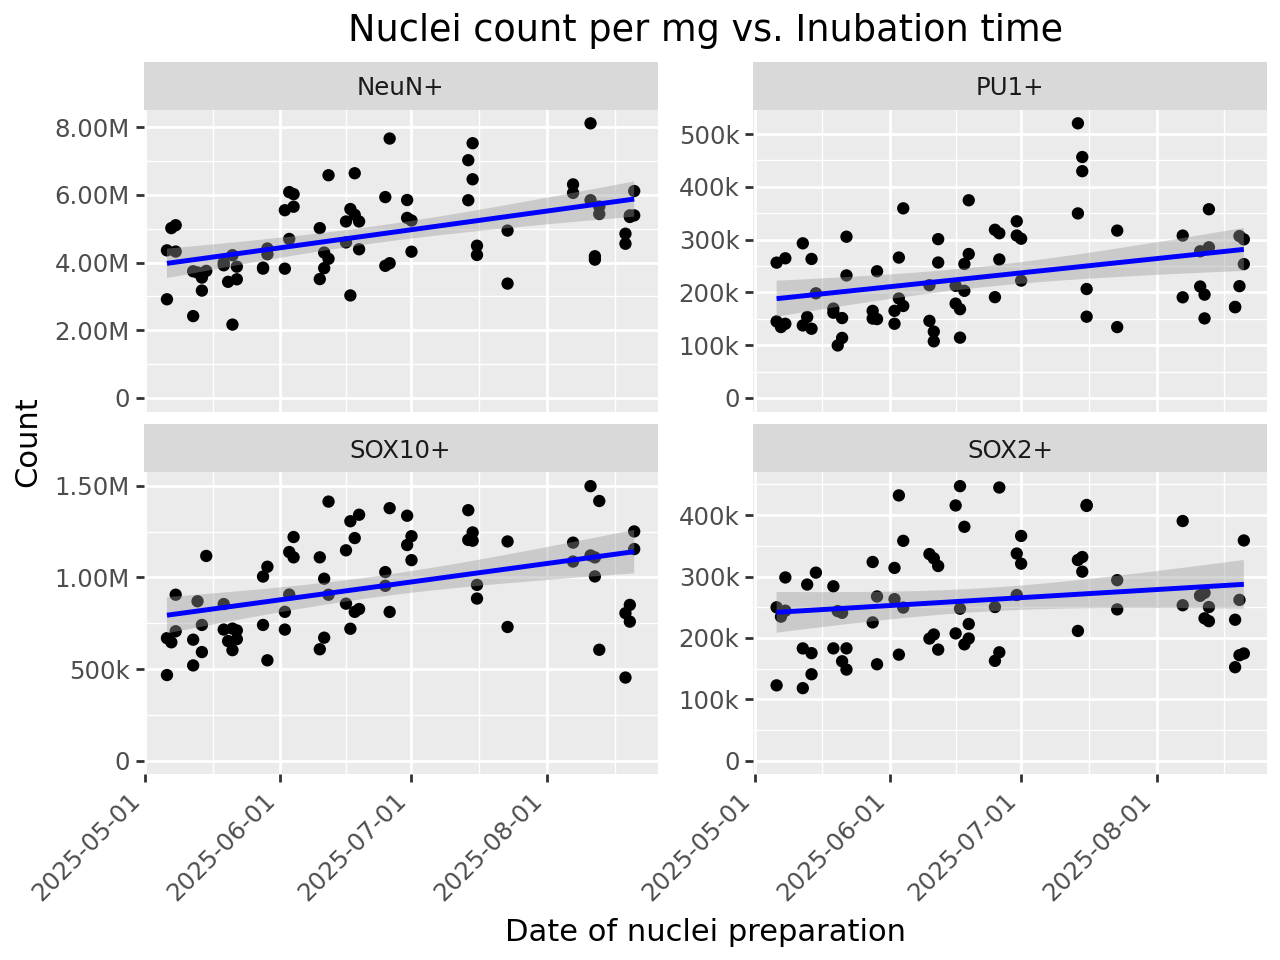

In [21]:
# Check the effect of nuclei prep date
p_date = (
    ggplot(df_raw, aes(x='date_nuc_prep', y='count_value'))
    + geom_point()
    + stat_smooth(method='lm', color='blue') 
    +facet_wrap('population', scales='free_y')
    +scale_y_metric()
    +expand_limits(y=0)
    +theme(axis_text_x=element_text(angle=45, hjust=1))
    +labs(
        title="Nuclei count per mg vs. Inubation time",
        x="Date of nuclei preparation",
        y="Count"
    )
)
p_date

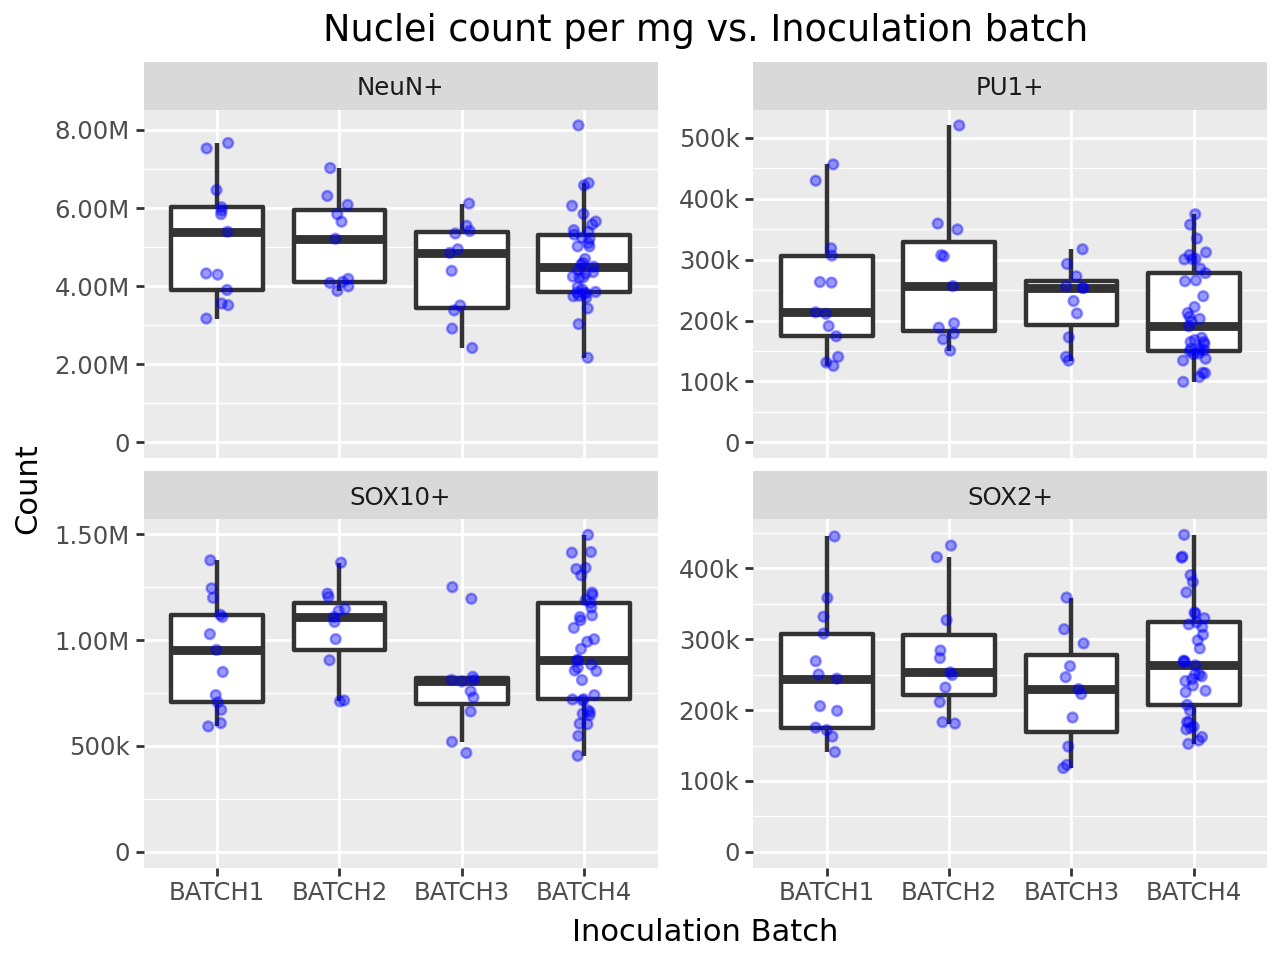

In [22]:
# check batch and counts
p_batch = (
    ggplot(data=df_raw, mapping=aes(x='inoculation_batch', y='count_value')) 
    +geom_boxplot(outlier_alpha=0, size=0.9, )
    +geom_jitter(width=0.1, alpha=0.4, color='blue')
    +facet_wrap('~ population', scales='free_y')
    +expand_limits(y=0)
    +scale_y_metric()
    +labs(
        title="Nuclei count per mg vs. Inoculation batch",
        x="Inoculation Batch",
        y="Count"
    )
)
p_batch

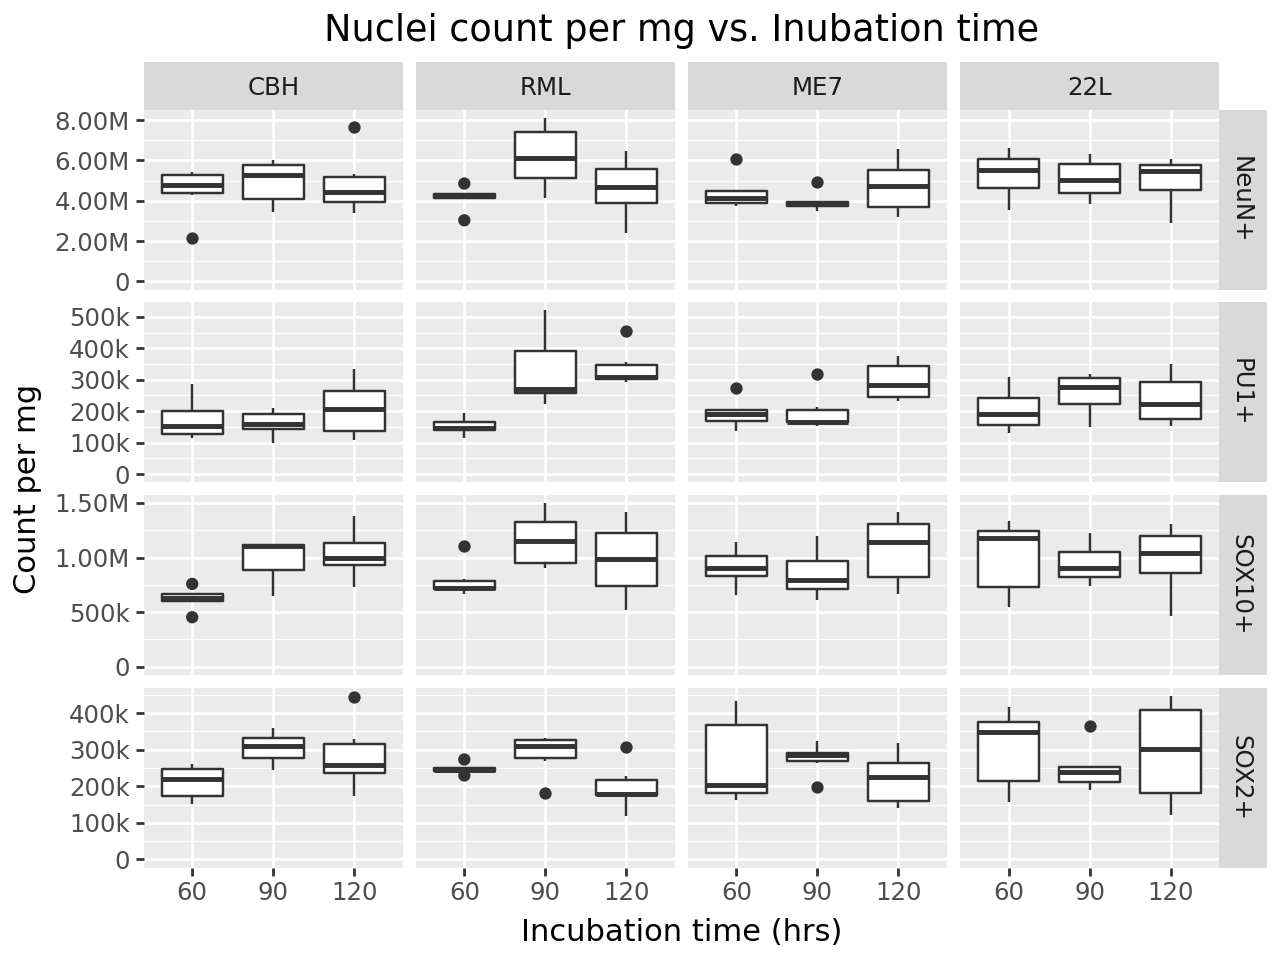

In [23]:
# boxplots for count per mg for every inoc*pop combination
p_box_raw = (
    ggplot(data=df_raw,mapping=aes(x='dpi', y='count_value')
) 
+ geom_boxplot()
+ facet_grid(rows='population', cols='inoculum', scales="free")
+expand_limits(y=0)
+scale_y_metric()
+labs(
        title="Nuclei count per mg vs. Inubation time",
        x="Incubation time (hrs)",
        y="Count per mg"
    )
)
p_box_raw

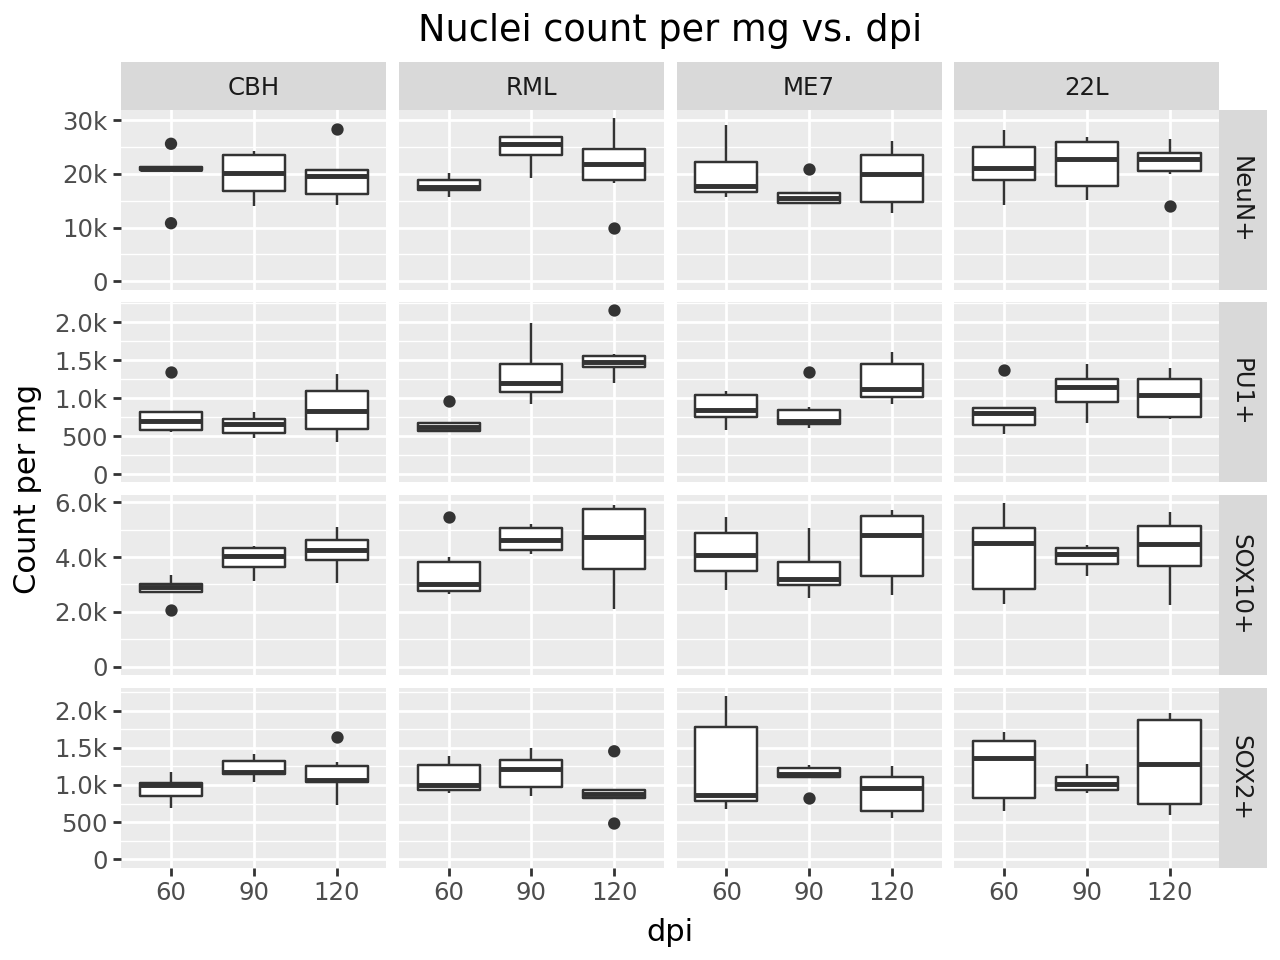

In [24]:
# boxplots for count per mg for every inoc*pop combination
p_box_norm = (
    ggplot(
    data=df_norm,
    mapping=aes(x='dpi', y='count_value')
) 
+ geom_boxplot()
+ facet_grid(rows='population', cols='inoculum', scales="free")
+expand_limits(y=0)
+ scale_y_metric()
+ labs(
        title="Nuclei count per mg vs. dpi",
        x="dpi",
        y="Count per mg"
    )

)
p_box_norm

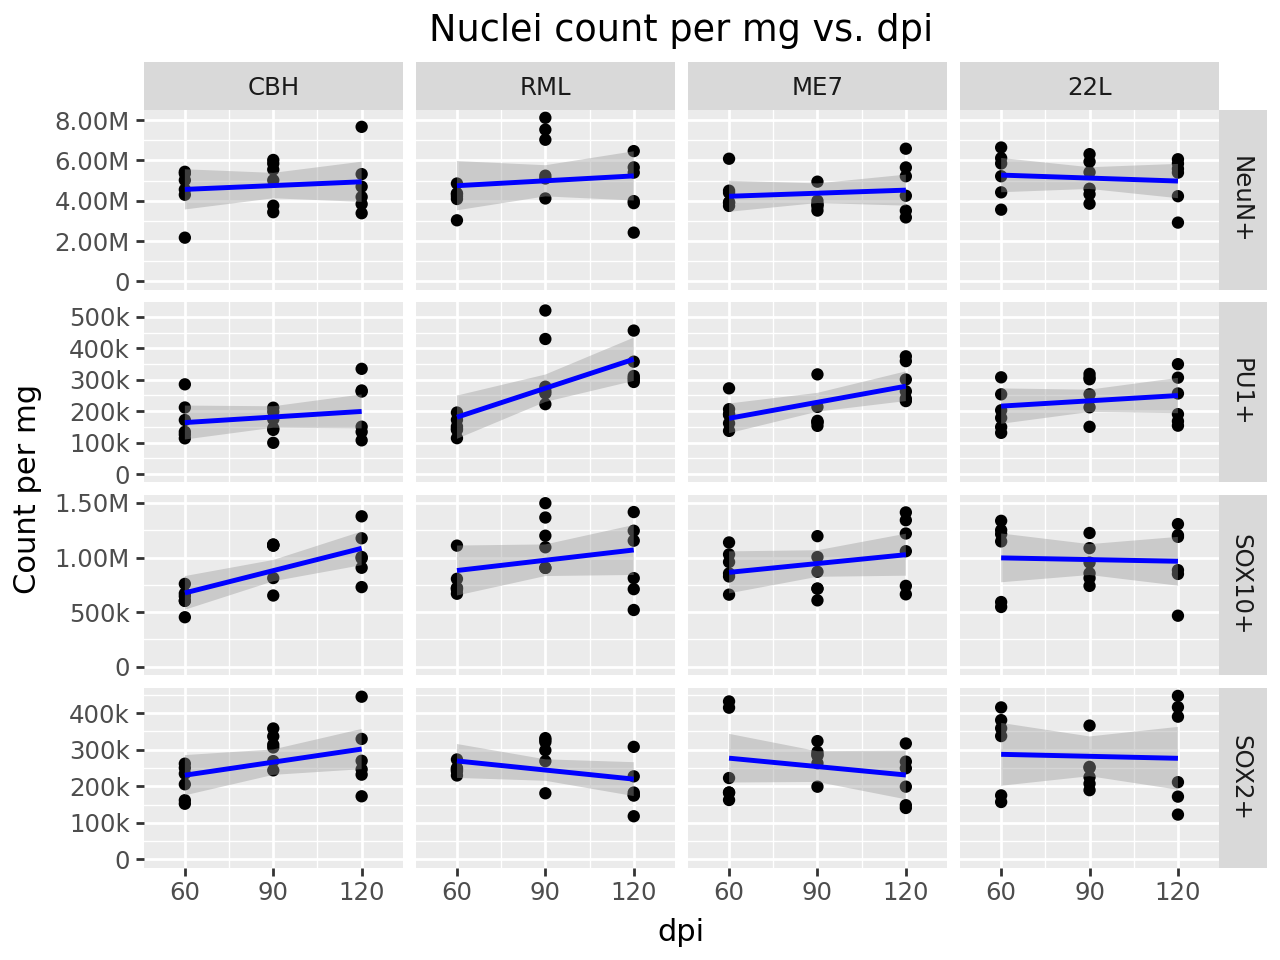

In [25]:
# Plotting count vs dpi as a scatter

# To do this, we need to encode dpi as an int again
df_dpi_int = df_raw.copy()
df_dpi_int['dpi'] = df_dpi_int['dpi'].astype('int64')

p_dpi_scat = (
    ggplot(
    data=df_dpi_int,
    mapping=aes(x='dpi', y='count_value')
) 
+ geom_point()
+ stat_smooth(method='lm', color='blue')
+ facet_grid(rows='population', cols='inoculum', scales="free")
+expand_limits(y=0)
+ scale_y_metric()
+scale_x_continuous(limits=(50, 130), breaks=[60, 90, 120])
+ labs(
        title="Nuclei count per mg vs. dpi",
        x="dpi",
        y="Count per mg"
    )
)
p_dpi_scat

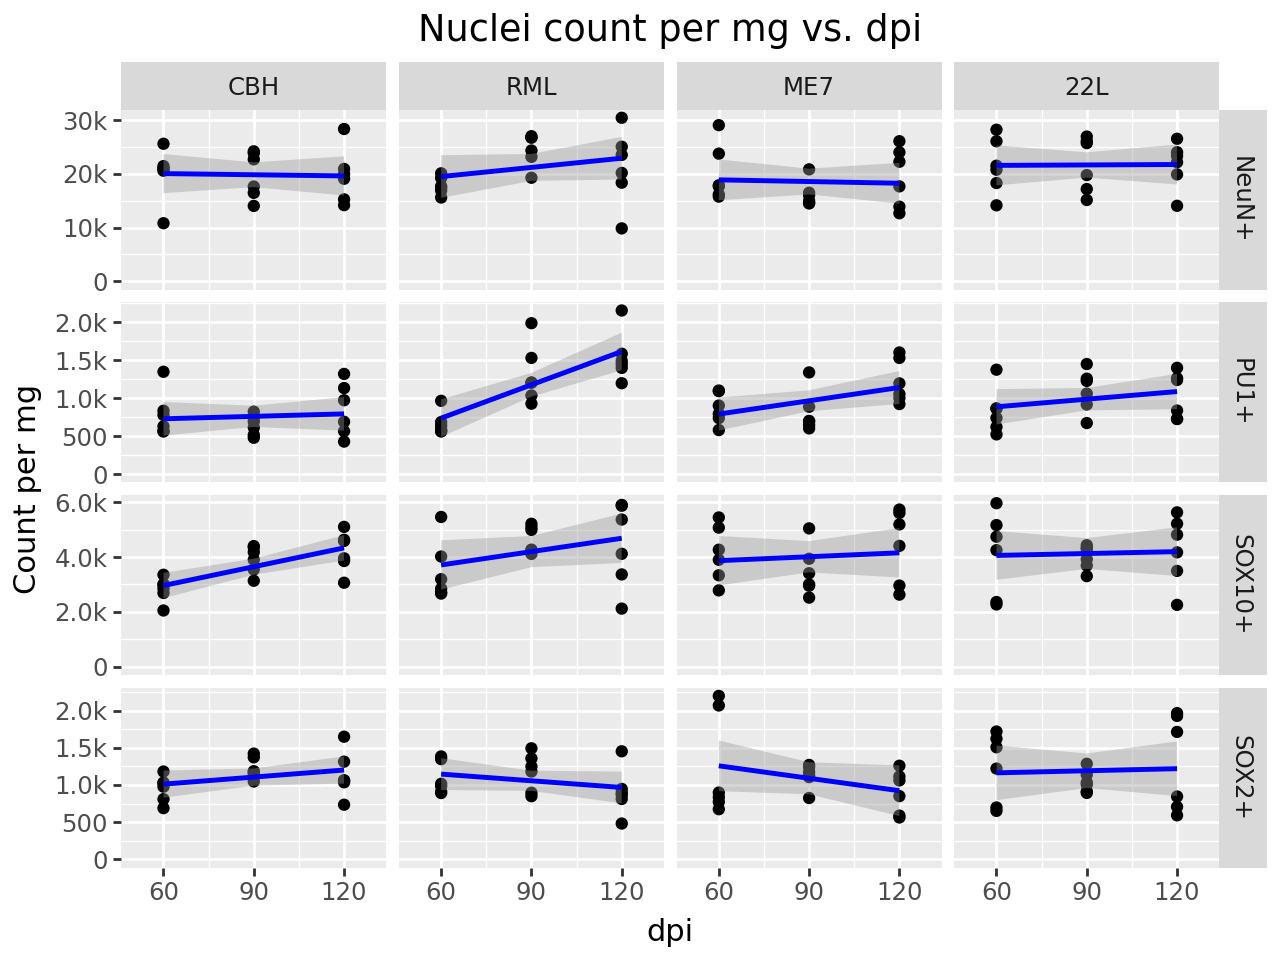

In [26]:
# Do exactly the same thing with the count per mg data
df_dpi_norm = df_norm.copy()
df_dpi_norm['dpi'] = df_dpi_norm['dpi'].astype('int64')


p_dpi_scat_norm = (
    ggplot(
    data=df_dpi_norm,
    mapping=aes(x='dpi', y='count_value')
) 
+ geom_point()
+ stat_smooth(method='lm', color='blue')
+ facet_grid(rows='population', cols='inoculum', scales="free")
+expand_limits(y=0)
+ scale_y_metric()
+scale_x_continuous(
    limits=(50, 130),
    breaks=[60, 90, 120]
)
+ labs(
        title="Nuclei count per mg vs. dpi",
        x="dpi",
        y="Count per mg"
    )

)
p_dpi_scat_norm

In [27]:
# Gather the names of the plot objects for exportation
plotnames = [name for name in globals().keys() if name.startswith('p_')]
plotnames

['p_mass_byPop',
 'p_mass_grid',
 'p_inc_byPop',
 'p_inc_byPop_norm',
 'p_inc_raw_noOutlier',
 'p_inc_norm_noOutlier',
 'p_inc_norm_grid',
 'p_date',
 'p_batch',
 'p_box_raw',
 'p_box_norm',
 'p_dpi_scat',
 'p_dpi_scat_norm']

In [28]:
filenames = [
    "exp383FANS_nucleiCountVsmass_byPop.png",
    "exp383FANS_nucleiCountVsmass_facetGrid.png",
    "exp383FANS_nucleiCountVsIncubation_byPop.png",
    "exp383FANS_nucleiCountPerMgVsIncubation_byPop.png",
    "exp383FANS_nucleiCountVsIncubationNoOutlier.png",
    "exp383FANS_nucleiCountPerMgVsIncubationNoOutlier.png",
    "exp383FANS_nucleiCountPerMgVsIncubationNoOutlierGrid.png",
    "exp383FANS_nucleiCountVsDate.png",
    "exp383FANS_nucleiCountVsBatch.png",
    "exp383FANS_nucleiCountVsDpi_facetGrid.png",
    "exp383FANS_nucleiCountPerMgVsDpi_facetGrid.png",
    "exp383FANS_nucleiCountVsDpi_scatter.png",
    "exp383FANS_nucleiCountPerMgVsDpi_scatter.png",  
]

In [29]:
# directory for the plots
outdir = base_path / "output" / "plots" 
outdir.mkdir(parents=True, exist_ok=True)

In [50]:
# Bulk save
for plotname, filename in zip(plotnames, filenames):
    plot_obj = globals()[plotname]

    save_path = outdir / filename  

    plot_obj.save(save_path, dpi=300, verbose=False)

## Section B: Formal model selection
In this section, I am testing out some newly learned stuff; it is certainly overkill for this analysis. Here, I show formally that the negative binomial model is a better fit for my data than the Poisson. A key difference between them is that the NB model accounts for overdispersion whereas the P model assumes the variance and mean are approximately equal
1. First, by calculating the variance:mean ratio
2. Via a dispersion test after fitting an intercept only model; we are looking to see how great the deviation from the Poisson distribution our data is
3. Fitting both an NB and Poisson model and comparing AIC values
4. Performing the likelihood ratio test with the two different models

In [40]:
# Assess the ratio of the variance to the mean
df_meanVar = (
    df_raw.groupby(['dpi', 'inoculum', 'population'])
    .agg(
        mean=('count_value', 'mean'),
        variance=('count_value', 'var')
    )
)
df_meanVar['var/mean'] = df_meanVar['variance'] / df_meanVar['mean']
df_meanVar.head() # variance >> mean

/tmp/ipykernel_945922/3734814704.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


mean             variance   var/mean
dpi inoculum population                                             
60  CBH      NeuN+      4,468,945.33 1,469,022,675,926.67 328,717.98
             PU1+         173,772.17     4,281,052,323.37  24,636.01
             SOX10+       622,822.33    10,132,249,717.07  16,268.28
             SOX2+        211,137.17     2,115,732,055.77  10,020.65
    RML      NeuN+      4,144,303.83   366,927,677,970.17  88,537.83

In [51]:
# Formal test of Poisson goodness of fit
# Fit minimal Poisson model (intercept only for raw dispersion test)

# Fit a minimal poisson model with only an intercept term
m_pois = smf.glm(
    "count_value ~ 1",
    data=df_raw,
    family=sm.families.Poisson()
).fit()

resid_deviance = m_pois.deviance
resid_df       = m_pois.df_resid
dispersion     = resid_deviance / resid_df

print("Residual deviance:", resid_deviance)
print("Residual df:", resid_df)
print("Dispersion:", dispersion)

Residual deviance: 611148138.3893344
Residual df: 287
Dispersion: 2129436.0222624894


In [66]:
# Compare Poisson and NB goodness of fit
# Poisson model

# NB model with intercept only (no predictors)
m_nb_basic = smf.glm(
    "count_value ~ 1",
    data=df_raw,
    family=sm.families.NegativeBinomial()
).fit()

# Poisson model with biological predictors
m_pois_biol = smf.glm(
    "count_value ~ dpi + inoculum + population",
    data=df_raw,
    family=sm.families.Poisson()
).fit()

# NB model with biological predictors
m_nb_biol = smf.glm(
    "count_value ~ dpi + inoculum + population",
    data=df_raw,
    family=sm.families.NegativeBinomial()
).fit()

# NB model with 

print("Poisson (Intercept only) AIC:", m_pois.aic)
print("Poisson (+Predictors) AIC:", m_pois_biol.aic)
print("NB AIC:     ", m_nb_basic.aic)
print("NB (+Predictors):", m_nb_biol.aic)

Poisson (Intercept only) AIC: 29003861.690800685
Poisson (+Predictors) AIC: 29003861.690800685
NB AIC:      8792.233545914758
NB (+Predictors): 8362.232568598818


/home/tmurphy/miniforge3/envs/generalPython/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
/home/tmurphy/miniforge3/envs/generalPython/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
